In [ ]:
import sys
import os
import glob
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import util_figures_psychophysics
import f0dl_bernox

sys.path.append('/om2/user/msaddler/pitchnet/assets_datasets/')
import stimuli_f0_labels

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_misc

# regex_fn_eval_validation = '/saved_models/arch_search_v02_topN/f0_label_*/arch_*/EVAL_validation_bestckpt.json'
regex_fn_eval_validation = '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v02/arch_????/EVAL_validation_bestckpt.json'
list_fn_eval_validation = sorted(glob.glob(regex_fn_eval_validation))

for fn_eval_validation in list_fn_eval_validation:
    with open(fn_eval_validation, 'r') as f:
        expt_dict = json.load(f)

    f0_label_pred_key = None
    for k in sorted(expt_dict.keys()):
        expt_dict[k] = np.array(expt_dict[k])
        if 'labels_pred' in k:
            f0_label_pred_key = k
    bin_width_N = ''
    for s in f0_label_pred_key:
        if s.isdigit():
            bin_width_N += s
    if len(bin_width_N) > 1:
        binwidth_N = int(bin_width_N)
    else:
        binwidth_N = 192

    kwargs_f0_bins = {'f0_min':80., 'f0_max':1e3, 'binwidth_in_octaves':1/binwidth_N}
    f0_bins = stimuli_f0_labels.get_f0_bins(**kwargs_f0_bins)
    IDX = np.array(expt_dict[f0_label_pred_key]) < len(f0_bins)
    expt_dict[f0_label_pred_key] = np.array(expt_dict[f0_label_pred_key])[IDX]
    expt_dict['f0'] = np.array(expt_dict['f0'])[IDX]
    print(f0_label_pred_key, IDX.sum())
    
    expt_dict = f0dl_bernox.add_f0_estimates_to_expt_dict(expt_dict,
                                                          f0_label_true_key='f0_label:labels_true',
                                                          f0_label_pred_key=f0_label_pred_key,
                                                          kwargs_f0_bins=kwargs_f0_bins,
                                                          kwargs_f0_octave={},
                                                          kwargs_f0_normalization={},
                                                          kwargs_f0_prior={})

    f0_true = expt_dict['f0']
    f0_pred = expt_dict['f0_pred']
    f0_pct_err = 100.0 * np.abs(f0_pred - f0_true) / f0_true
    
    results_dict = {
        "f0_pct_error_mean": np.mean(f0_pct_err),
        "f0_pct_error_median": np.median(f0_pct_err),
    }
    
    fn_results_dict = fn_eval_validation.replace('.json', '_results_dict.json')
    with open(fn_results_dict, 'w') as f:
        print('WRITING: {}'.format(fn_results_dict))
        json.dump(results_dict, f, cls=util_misc.NumpyEncoder, sort_keys=True)

    print(os.path.basename(os.path.dirname(fn_eval_validation)), np.mean(f0_pct_err), np.median(f0_pct_err))



f0_label_024 10 1.94357693885276
f0_label_048 10 1.1570294887591743
f0_label_096 10 0.7489587541220886
f0_label_192 10 0.6496892096161794
f0_label_384 10 0.6319681715890568


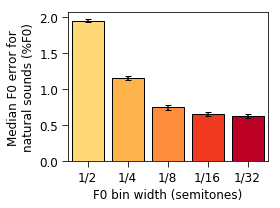

In [6]:
import sys
import os
import glob
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import util_figures_psychophysics
import f0dl_bernox

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_misc

regex_fn_results_dict = '/saved_models/arch_search_v02_topN/f0_label_*/arch_0???/EVAL_validation_bestckpt_results_dict.json'
list_fn_results_dict = sorted(glob.glob(regex_fn_results_dict))

dict_median_f0_err = {}
dict_bin_width = {}

for fn_results_dict in list_fn_results_dict:
    tmp = fn_results_dict.split('/')
    model_name = tmp[3]
#     model_name = os.path.basename(os.path.dirname(fn_results_dict))
#     model_name = model_name[:model_name.find('_PND')]
#     if len(model_name) > 20:
#         model_name = 'f0_label_192'
    bin_width = 12 / int(model_name[-3:])
    
    with open(fn_results_dict, 'r') as f:
        results_dict = json.load(f)
    
    if not model_name in dict_median_f0_err.keys():
        dict_median_f0_err[model_name] = []
        dict_bin_width[model_name] = []
    dict_median_f0_err[model_name].append(results_dict['f0_pct_error_median'])
    dict_bin_width[model_name].append(bin_width)
    
dict_median_f0_err, dict_bin_width


fig, ax = plt.subplots(figsize=(4, 3))

list_bin_width = [1/2, 1/4, 1/8, 1/16, 1/32]
xticklabels = ['1/2', '1/4', '1/8', '1/16', '1/32']
list_color = ['#fed976', '#feb24c', '#fd8d3c', '#f03b20', '#bd0026']
for key in sorted(dict_bin_width.keys()):
    print(key, len(dict_median_f0_err[key]), np.mean(dict_median_f0_err[key]))
    yval, yerr = util_figures_psychophysics.bootstrap(np.array(dict_median_f0_err[key]))
    xval = list_bin_width.index(np.mean(dict_bin_width[key]))
    cidx = list_bin_width.index(np.mean(dict_bin_width[key]))
    bar_kwargs = {
        'yerr': 2*yerr,
        'color': list_color[cidx],
        'width': 0.8,
        'capsize': 3,
        'edgecolor': 'k',
        'ecolor': 'k',
        'linewidth': 1,
        'error_kw': {
            'capthick': 1
        }
    }
    ax.bar(xval, yval, **bar_kwargs)

ax = util_figures.format_axes(ax,
                              str_xlabel='F0 bin width (semitones)',
                              str_ylabel='Median F0 error for\nnatural sounds (%F0)',
                              xlimits=[-0.5, 4.5],
                              xticks=[0, 1, 2, 3, 4],
                              xticks_minor=[],
                              xticklabels=xticklabels,
                              spines_to_hide=[])
plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_09_26_pitchnet_paper_figures_v03/'
# save_fn = os.path.join(save_dir, 'psychophysics_medianF0error_manipulation_f0_bin_width.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=False)


Loaded results from 40 files (EVAL_SOFTMAX_lowharm_v01_bestckpt_results_dict.json)
50Hz (0100 ANF) 10
50Hz (0250 ANF) 10
50Hz (1000 ANF) 10
50Hz (0500 ANF) 10
50Hz (1000 ANF)
50Hz (0500 ANF)
50Hz (0250 ANF)
50Hz (0100 ANF)


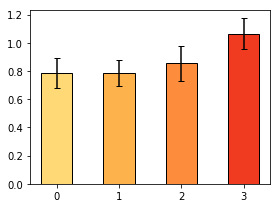

In [21]:
import sys
import os
import json
import numpy as np
import glob
import copy
import importlib
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
import util_figures_psychophysics
importlib.reload(util_figures_psychophysics)

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures


### SPECIFY THE OUTERMOST DIRECTORY CONTAINING ALL MODELS
model_dir = '/om2/user/msaddler/pitchnet/saved_models/'

### SPECIFY RESULTS DICT BASENAME: determines which experiment to plot
results_dict_basename = 'EVAL_SOFTMAX_lowharm_v01_bestckpt_results_dict.json'

### SPECIFY REGULAR EXPRESSIONS FOR MODELS: (regex, model_name) pairs
master_list = [
    ('/saved_models/arch_search_v02_topN/REDOsr2000_cf1000_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', '50Hz (1000 ANF)'),
    ('/saved_models/arch_search_v02_topN/REDOsr2000_cfI500_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', '50Hz (0500 ANF)'),
    ('/saved_models/arch_search_v02_topN/REDOsr2000_cfI250_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', '50Hz (0250 ANF)'),
    ('/saved_models/arch_search_v02_topN/REDOsr2000_cfI100_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', '50Hz (0100 ANF)'),
#     ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0050Hz_IHC7order/arch_0???/', '50Hz'),
#     ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0250Hz_IHC7order/arch_0???/', '250Hz'),
#     ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC0320Hz_IHC7order/arch_0???/', '320Hz'),
#     ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC1000Hz_IHC7order/arch_0???/', '1000Hz'),
#     ('/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/', '3000Hz'),
#     ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC6000Hz_IHC7order/arch_0???/', '6000Hz'),
#     ('/saved_models/arch_search_v02_topN/REDOsr20000_cf100_species002_spont070_BW10eN1_IHC9000Hz_IHC7order/arch_0???/', '9000Hz'),
]

### LOAD PSYCHOPHYSICS EXPERIMENT RESULTS
model_keys = []
results_dicts = {}
master_count = 0
for fn_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    if not fn_regex[0] == '/': fn_regex = os.path.join(model_dir, fn_regex)
    if '.json' not in fn_regex: fn_regex = os.path.join(fn_regex, results_dict_basename)
    for results_dict_fn in sorted(glob.glob(fn_regex)):
        master_count = master_count + 1
        with open(results_dict_fn) as f:
            results_dicts[model_key].append(json.load(f))

print('Loaded results from {} files ({})'.format(master_count, results_dict_basename))
for key in results_dicts.keys():
    print(key, len(results_dicts[key]))

    
fig, ax = plt.subplots(figsize=(4, 3))


list_color = ['#fed976', '#feb24c', '#fd8d3c', '#f03b20', '#bd0026']
for itr0, model_key in enumerate(model_keys):
    list_f0dl = []
    for rd in results_dicts[model_key]:
        list_f0dl.append(rd['f0dl'][0])
    list_f0dl = np.array(list_f0dl)
    yval, yerr = util_figures_psychophysics.bootstrap(list_f0dl)
#     yval = np.exp(yval)
#     yerr = np.exp(yerr)
    print(model_key)
    xval = itr0
    bar_kwargs = {
        'yerr': 2*yerr,
        'color': list_color[itr0],
        'width': 0.5,
        'capsize': 3,
        'edgecolor': 'k',
        'ecolor': 'k',
        'linewidth': 1,
        'error_kw': {
            'capthick': 1
        }
    }
    ax.bar(xval, yval, **bar_kwargs)

ax = util_figures.format_axes(ax,
                              str_xlabel='Number of CFs',
                              str_ylabel='Median F0 error for\nnatural sounds (%F0)',
                              xlimits=[-0.5, 4.5],
                              xticks=[0, 1, 2, 3, 4],
                              xticks_minor=[],
                              xticklabels=xticklabels,
                              spines_to_hide=[])
plt.tight_layout()
plt.show()


In [16]:
results_dicts[model_key][0].keys()

print(results_dicts[model_key][0]['f0dl'])
print(results_dicts[model_key][0]['low_harm'])
print(results_dicts[model_key][0]['phase_mode'])

[0.8035188030890645, 1.6877968295941261, 11.88526086886566, 233.1672096154774, 371835452.5277252, 990969038.3026708, 76882987.24020483, 682.1124951741301, 1011532866.6060808, 126.93503899894843, 67.55538073908617, 615278051.856235, 240267528.1012106, 984274662.2356178, 83.73034099016508, 1087308097.3793085, 1103754028.8153822, 583735112.9841478, 344532003.63678145, 154.76919404036033, 174.97354757457865, 64.9646983845705, 120.49833079076281, 269760003.4191956, 1000634208.7866602, 26.351875620081127, 941088166.0004303, 931.2238393515368, 1219420702.977164, 841110109.8655443, 0.9179074437718328, 2.0248055516490844, 8.77855554274337, 34.89793831641273, 166246475.4518905, 132.1639649879285, 400.672863808997, 1199449629.3294168, 515004751.86303204, 287.5923472373968, 338.93247393428396, 802.9032648346629, 657698803.0408307, 722150458.5473152, 274.1721567761757, 1293733698.0722175, 90.47656156385042, 151.40281073220027, 316483403.3077585, 256.5833634286731, 161359905.68952283, 916.3181533423

In [16]:
import os
import sys
import json
import glob
import importlib
import numpy as np
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli

sys.path.append('../assets_psychophysics/')
import f0dl_bernox
import f0dl_bernox_exact
import util_figures_psychophysics

importlib.reload(f0dl_bernox_exact)
importlib.reload(util_figures_psychophysics)

# regex_json_eval_fn = '/om2/user/msaddler/pitchnet/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/EVAL_SOFTMAX_exact_v00_bestckpt.json'
# kwargs_f0_prior = {
#     'f0_label_prob_key': 'f0_label:probs_out',
#     'f0_prior_ref_key': 'f0',
#     'octave_range': [-0.5, 0.5],
# }
# for json_eval_fn in sorted(glob.glob(regex_json_eval_fn)):
#     complete_results_dict = f0dl_bernox_exact.main(json_eval_fn,
#                                                    save_results_to_file=True,
#                                                    kwargs_f0_prior=kwargs_f0_prior)



<module 'util_figures_psychophysics' from '/rdma/vast-rdma/vast/mcdermott/msaddler/pitchnet/assets_psychophysics/util_figures_psychophysics.py'>

Filter low frequency cutoff = 1250Hz (n=10)


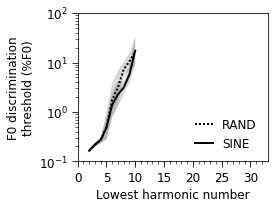

Filter low frequency cutoff = 2500Hz (n=10)


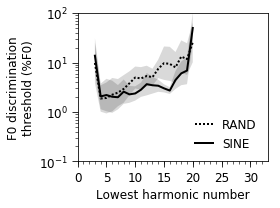

Filter low frequency cutoff = 3750Hz (n=10)


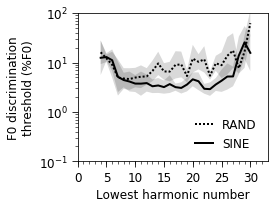

Filter low frequency cutoff = 5000Hz (n=10)


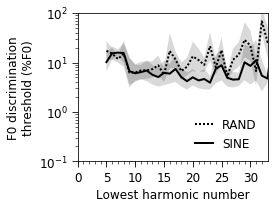

In [17]:
regex_results_dict_fn = '/om2/user/msaddler/pitchnet/saved_models/arch_search_v02_topN/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/arch_0???/EVAL_SOFTMAX_exact_v00_bestckpt_results_dict.json'

list_results_dict = []
for results_dict_fn in sorted(glob.glob(regex_results_dict_fn)):
    with open(results_dict_fn) as f:
        results_dict = json.load(f)
    results_dict.pop('psychometric_function')
    for k in sorted(results_dict.keys()):
        results_dict[k] = np.array(results_dict[k])
    list_results_dict.append(results_dict)

for fl in np.unique(results_dict['fl']):
    results_dict_input = []
    for rd in list_results_dict:
        results_dict_input.append(f0dl_bernox.filter_expt_dict(rd, filter_dict={'fl': fl}))
    
    print('Filter low frequency cutoff = {}Hz (n={})'.format(fl, len(results_dict_input)))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), gridspec_kw={})
    util_figures_psychophysics.make_bernox_threshold_plot(ax, results_dict_input, include_yerr=True)
    plt.tight_layout()
    plt.show()



2 0.15778876257239904
3 0.21495080248543214
4 0.24799655624166084
5 0.3622886622222585
6 6.121293304644553
7 7.372012437387008
8 2.423678586323573
9 8.498230040087815
10 13.754349745730252


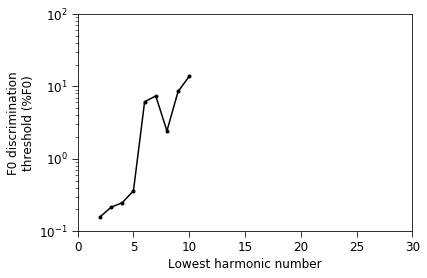

In [37]:
bin_width=5e-2
mu=0
threshold_value=0.707


list_low_harm = []
list_f0dl = []
for lh in np.unique(low_harm_pairs[:, 0]):
    IDX = np.logical_and(low_harm_pairs[:, 0] == lh, low_harm_diffs == 0)
#     IDX = np.logical_and(IDX, true_pct_diffs < 2)
#     IDX = low_harm_means == lh
    bins, bin_means = f0dl_bernox.get_empirical_psychometric_function(true_pct_diffs[IDX],
                                                                      judgments[IDX],
                                                                      bin_width=bin_width)
    sigma_opt, sigma_opt_cov = f0dl_bernox.fit_normcdf(bins, bin_means, mu=mu)
    f0dl = scipy.stats.norm(mu, sigma_opt).ppf(threshold_value)
    
    list_f0dl.append(f0dl)
    list_low_harm.append(lh)
    
#     fig, ax = plt.subplots()
#     ax.plot(bins, bin_means, '.')
#     ax.plot(bins, scipy.stats.norm(mu, sigma_opt).cdf(bins), 'r-')
#     ax.set_ylim([0, 1])
#     plt.show()
    
    print(lh, f0dl)

fig, ax = plt.subplots()
ax.plot(list_low_harm, list_f0dl, 'k.-')
ax = util_figures.format_axes(ax,
                                  str_xlabel='Lowest harmonic number',
                                  str_ylabel='F0 discrimination\nthreshold (%F0)',
                                  fontsize_labels=12,
                                  fontsize_ticks=12,
                                  fontweight_labels=None,
                                  xscale='linear',
                                  yscale='log',
                                  xlimits=[0, 30],
                                  ylimits=[0.1, 100],
                                  yticks=None,
                                  yticks_minor=None,
                                  xticklabels=None,
                                  yticklabels=None,
                                  spines_to_hide=[],
                                  major_tick_params_kwargs_update={},
                                  minor_tick_params_kwargs_update={})


In [ ]:
import sys
import os
import json
import numpy as np
import glob
import f0dl_bernox
%matplotlib inline
import matplotlib.pyplot as plt

json_regex = '/om2/user/msaddler/pitchnet/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt.json'
json_fn_list = sorted(glob.glob(json_regex))

print('found {} files'.format(len(json_fn_list)))

results_dict_list = []

for fn in json_fn_list:
    print(fn)
    
    metadata_key_list=['low_harm', 'phase_mode', 'f0', 'base_f0']
    results_dict = f0dl_bernox.run_f0dl_experiment(
        fn,
        max_pct_diff=3,
        bin_width=5e-2,
        use_empirical_f0dl_if_possible=False,
        metadata_key_list=metadata_key_list,
        f0_label_true_key='f0_label:labels_true',
        f0_label_pred_key='f0_label:labels_pred',
        f0_label_prob_key='f0_label:probs_out',
        kwargs_f0_bins={},
        kwargs_f0_octave={},
        kwargs_f0_normalization={},
        kwargs_f0_prior={},
        f0_min=300,
        f0_max=301,
        max_processes=60)

    results_dict_list.append(results_dict)
    


In [ ]:
import util_figures_psychophysics

NROWS = 1
NCOLS = 1
figsize = (4*NCOLS*0.9, 3*NROWS*0.9)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = np.array(ax).reshape([-1])

plot_fcn = util_figures_psychophysics.make_bernox_threshold_plot
kwargs = {
    'include_yerr': True,
    'str_title': 'F0 = 300Hz'
#     'sine_plot_kwargs': {'label': key, 'color': color_list[ax_idx]},
#     'rand_plot_kwargs': {'label': None, 'color': color_list[ax_idx]},
}
plot_fcn(ax[0], results_dict_list, **kwargs)

plt.tight_layout()
plt.show()

# fig.savefig('tmp.pdf', bbox_inches='tight')


In [ ]:
base_f0_min=100.0
base_f0_max=300.0
base_f0_n=10
base_f0_list = np.power(2, np.linspace(np.log2(base_f0_min), np.log2(base_f0_max), base_f0_n))
base_f0_list


In [ ]:
import sys
import os
import json
import numpy as np
import glob
import copy
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.stats

import importlib
import util_human_model_comparison
import util_figures_psychophysics

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures

regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/'

# Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_SOFTMAX_oxenham2004_080to320Hz_v01_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_SOFTMAX_mooremoore2003_080to480Hz_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_SOFTMAX_MistunedHarm_v01_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json',
    'snr_per_component': 'EVAL_SOFTMAX_mcpherson2020_testSNR_v01_bestckpt_results_dict.json',
}

# Specify list of experiments to load
experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
    'snr_per_component',
]

list_model_dir = []
dict_results_dicts = {ek: [] for ek in experiment_keys}

for idx, model_dir in enumerate(sorted(glob.glob(regex_model_dir))):
    fn_result_dict = {
        ek: os.path.join(model_dir, experiment_to_basename_map[ek]) for ek in experiment_keys
    }
    include_model_flag = True
    for ek in experiment_keys:
        if not os.path.exists(fn_result_dict[ek]): include_model_flag = False
    if include_model_flag:
        list_model_dir.append(model_dir)
        # Load results_dict for each model
        for ek, results_dict_fn in fn_result_dict.items():
            with open(results_dict_fn) as f:
                dict_results_dicts[ek].append(json.load(f))

print(regex_model_dir, len(list_model_dir))


In [ ]:
# experiment_key = 'transposedtones'
# key_outer = 'f0_ref'
# key_inner = 'f_carrier'

experiment_key = 'bernox2005'
key_outer = 'low_harm'
key_inner = 'phase_mode'

experiment_key = 'snr_per_component'
key_outer = 'snr_per_component'
key_inner = 'json_eval_fn'

rd0 = dict_results_dicts[experiment_key][0]

color_list = util_figures.get_color_list(8, cmap_name='Dark2')

for val_outer in np.unique(rd0[key_outer]):
    plt.figure()
    for cidx, val_inner in enumerate(np.unique(rd0[key_inner])):
        IDX = np.logical_and(np.array(rd0[key_outer]) == val_outer,
                             np.array(rd0[key_inner]) == val_inner)

        psy_d = np.array(rd0['psychometric_function'])[IDX][0]
        x = np.array(psy_d['bins'])
        y = np.array(psy_d['bin_means'])
        normcdf = lambda _: scipy.stats.norm(psy_d['mu'], psy_d['sigma']).cdf(_)
        plt.plot(x, y, '.',
#                  label='{}={}'.format(key_inner , val_inner),
                 color=color_list[cidx])
        plt.plot(x, normcdf(x), '-', lw=1, color=color_list[cidx])

    plt.legend()
    plt.title('{}={}'.format(key_outer , val_outer))
    plt.show()


In [ ]:
import os
import sys
import json
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.ticker

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli

sys.path.append('../assets_datasets/')
import stimuli_f0_labels

sys.path.append('../assets_psychophysics/')
import f0dl_bernox


regex_model_dir = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/'
model_dir = glob.glob(regex_model_dir)[1]


experiment_to_basename_map = {
    'bernox2005': 'EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_SOFTMAX_oxenham2004_080to320Hz_v01_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_SOFTMAX_mooremoore2003_080to480Hz_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_SOFTMAX_MistunedHarm_v01_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json',
}
experiment_to_metadata_key_list_map = {
    'bernox2005': ['low_harm', 'phase_mode', 'f0'],
    'transposedtones': ['f_carrier', 'f0'],
    'freqshiftedcomplexes': [
        'f0',
        'f0_shift',
        'spectral_envelope_centered_harmonic',
        'spectral_envelope_bandwidth_in_harmonics',
    ],
    'mistunedharmonics': ['f0', 'mistuned_harm', 'mistuned_pct'],
    'altphasecomplexes': ['f0', 'phase_mode', 'filter_fl', 'filter_fh'],
}

experiment_key = 'transposedtones'

list_expt_dict = []
for model_dir in sorted(glob.glob(regex_model_dir)):
    fn = os.path.join(model_dir, experiment_to_basename_map[experiment_key])
    fn = fn.replace('_results_dict', '')

    metadata_key_list =  experiment_to_metadata_key_list_map[experiment_key]
    expt_dict = f0dl_bernox.load_f0_expt_dict_from_json(fn, metadata_key_list=metadata_key_list)
    kwargs_f0_prior = {
        'f0_label_prob_key': 'f0_label:probs_out',
        'f0_prior_ref_key': 'f0',
        'octave_range': [
            -0.5,
            0.5
        ],
    }
    expt_dict = f0dl_bernox.add_f0_estimates_to_expt_dict(expt_dict, kwargs_f0_prior=kwargs_f0_prior)
    list_expt_dict.append(expt_dict)


In [ ]:
key_col = 'f_carrier'
# key_col = 'low_harm'
# key_col = 'mistuned_harm'
# key_col = 'spectral_envelope_centered_harmonic'

list_val_col = np.unique(expt_dict[key_col])
# list_val_col = [1, 2, 4, 8, 16]

nrows = len(list_expt_dict)
ncols = len(list_val_col)
fig, ax = plt.subplots(nrows=nrows,
                       ncols=ncols,
                       figsize=(2.5*ncols, 2.5*nrows),
                       sharex=True,
                       sharey=True)

for c, val_col in enumerate(list_val_col):    
    for r, expt_dict in enumerate(list_expt_dict):
        sub_expt_dict = f0dl_bernox.filter_expt_dict(expt_dict, filter_dict={key_col: val_col})
        f0_true = sub_expt_dict['f0'].reshape([-1, 1])
        f0_pred = sub_expt_dict['f0_pred'].reshape([-1, 1])
#         f0_pred_oct = f0_pred * np.power(2., np.arange(-4, 5, 1)).reshape([1, -1])
#         f0_err_vals = np.abs(f0_pred_oct - f0_true) / f0_true
#         IDX = np.argmin(f0_err_vals, axis=1)
#         xvals = []
#         yvals = []
#         for itr0 in range(f0_true.shape[0]):
#             xvals.append(f0_true[itr0, 0])
#             yvals.append(f0_pred_oct[itr0, IDX[itr0]])
        xvals = np.squeeze(f0_true)
        yvals = np.squeeze(f0_pred)
        ax[r, c].plot(xvals, xvals, 'r--')
        ax[r, c].plot(xvals, yvals, 'k.', ms=0.1)
        ax[r, c].set_xscale('log')
        ax[r, c].set_yscale('log')
        
        if r == 0:
            if len(key_col) > 10:
                title_str = '{}={}'.format(key_col[:10], val_col)
            else:
                title_str = '{}={}'.format(key_col, val_col)
            ax[r, c].set_title(title_str)

plt.tight_layout()
plt.show()


In [ ]:
f0_ref = 113.13708499

f0_ref_min = 80
f0_ref_max = 320
f0_ref_n_step = 5
f0_ref_list = np.power(2, np.linspace(np.log2(f0_ref_min), np.log2(f0_ref_max), f0_ref_n_step))
print(f0_ref_list)

for f0_ref in f0_ref_list:
    max_pct_diff = 100/6
    f0_range = [f0_ref * (1.0-max_pct_diff/100.0), f0_ref * (1.0+max_pct_diff/100.0)]
    print(f0_ref, f0_range)


In [ ]:
import os
import sys
import json
import glob
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.ticker

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli

sys.path.append('../assets_datasets/')
import stimuli_f0_labels

sys.path.append('../assets_psychophysics/')
import f0dl_bernox
import util_figures_psychophysics

results_dict_fn = '/saved_models/arch_0302_PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification9/EVAL_SOFTMAX_pitchrepnet_eval2afc_bernox2005_sr32000_dur150ms_bestckpt_results_dict.json'
with open(results_dict_fn) as f:
    results_dict = json.load(f)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), gridspec_kw={})
util_figures_psychophysics.make_bernox_threshold_plot(ax, results_dict)
plt.tight_layout()
plt.show()


In [5]:
### First pass at generating F0DL vs. low_harm results for Bryan's F0 estimation classifiers

import os
import sys
import json
import glob
import numpy as np
import pdb
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.ticker

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli

sys.path.append('/om2/user/msaddler/pitchnet/assets_datasets/')
import stimuli_f0_labels

sys.path.append('/om2/user/msaddler/pitchnet/assets_datasets/')
import f0dl_bernox
import util_figures_psychophysics

import itertools
import functools
import multiprocessing


def run_f0dl_experiment(json_fn,
                        max_pct_diff=100/6,
                        noise_stdev=1e-12,
                        bin_width=5e-2,
                        mu=0.0,
                        threshold_value=0.707,
                        use_empirical_f0dl_if_possible=False,
                        f0_label_true_key='label',
                        f0_label_pred_key='pred',
                        f0_label_prob_key='f0_label:probs_out',
                        kwargs_f0_bins={'f0_min': 80.0, 'f0_max': 640.0, 'binwidth_in_octaves': 2/192},
                        kwargs_f0_octave={},
                        kwargs_f0_normalization={},
                        kwargs_f0_prior={},
                        f0_min=-np.inf,
                        f0_max=np.inf,
                        metadata_key_list=['low_harm', 'phase_mode', 'f0', 'bandpass_fl'],
                        low_harm_min=1,
                        low_harm_max=30,
                        max_processes=60):
    '''
    Main routine for simulating f0 discrimination experiment from Bernstein & Oxenham (2005, JASA).
    Function computes f0 discrimination thresholds as a function of lowest harmonic number and
    phase mode.
    
    Args
    ----
    json_fn (str): json filename to load
    max_pct_diff (float): pairs of f0 predictions are only compared if their pct_diff <= max_pct_diff
    noise_stdev (float): standard deviation of decision-stage noise
    bin_width (float): width of bin used to digitize pct_diffs
    mu (float): fixed mean of fitted normcdf
    threshold_value (float): value of the fitted normcdf used to compute f0 difference limen
    use_empirical_f0dl_if_possible (bool): if True, empirical f0dl will attempt to overwrite one computed from fit
    f0_label_true_key (str): key for f0_label_true in the json file
    f0_label_pred_key (str): key for f0_label_pred in the json file
    f0_label_prob_key (str): key for f0_label_pred probabilities in the json file
    kwargs_f0_bins (dict): kwargs for computing f0 bins (lower bound used as estimate)
    kwargs_f0_octave (dict): kwargs for converting f0s from Hz to octaves
    kwargs_f0_normalization (dict): kwargs for normalizing f0s
    kwargs_f0_prior (dict): kwargs for using a prior to compute f0_pred
    f0_min (float): use this argument to limit the f0 range used to compute thresholds (Hz)
    f0_max (float): use this argument to limit the f0 range used to compute thresholds (Hz)
    metadata_key_list (list): metadata keys in json file to use for experiment (see `load_f0_expt_dict_from_json()`)
    max_processes (int): use this argument to cap the number of parallel processes
    
    Returns
    -------
    results_dict (dict): contains lists of thresholds and psychometric functions for all conditions
    '''
    # Load JSON file of model predictions into `expt_dict`
    expt_dict = f0dl_bernox.load_f0_expt_dict_from_json(json_fn,
                                            f0_label_true_key=f0_label_true_key,
                                            f0_label_pred_key=f0_label_pred_key,
                                            f0_label_prob_key=f0_label_prob_key,
                                            metadata_key_list=metadata_key_list)
    expt_dict['base_f0'] = expt_dict['bandpass_fl']
    expt_dict = f0dl_bernox.add_f0_estimates_to_expt_dict(expt_dict,
                                              f0_label_true_key=f0_label_true_key,
                                              f0_label_pred_key=f0_label_pred_key,
                                              kwargs_f0_bins=kwargs_f0_bins,
                                              kwargs_f0_octave=kwargs_f0_octave,
                                              kwargs_f0_normalization=kwargs_f0_normalization,
                                              kwargs_f0_prior=kwargs_f0_prior)
    expt_dict = f0dl_bernox.filter_expt_dict(expt_dict, filter_dict={'f0':[f0_min, f0_max]})
    
    unique_phase_mode_list = np.unique(expt_dict['phase_mode'])
    unique_low_harm_list = np.unique(expt_dict['low_harm'])
    unique_low_harm_list = unique_low_harm_list[np.logical_and(unique_low_harm_list >= low_harm_min,
                                                               unique_low_harm_list <= low_harm_max)]
    print('low_harm_list', unique_low_harm_list)
    N = len(unique_phase_mode_list) * len(unique_low_harm_list)
    # Initialize dictionary to hold psychophysical results
    results_dict = {
        'phase_mode': [None]*N,
        'low_harm': [None]*N,
        'f0dl': [None]*N,
        'psychometric_function': [None]*N,
    }
#     par_idx, sub_results_dict = f0dl_bernox.parallel_run_f0dl_experiment(
#         0,
#         expt_dict=expt_dict,
#         unique_phase_mode_list=unique_phase_mode_list,
#         unique_low_harm_list=unique_low_harm_list,
#         max_pct_diff=max_pct_diff,
#         noise_stdev=noise_stdev,
#         bin_width=bin_width,
#         mu=mu,
#         threshold_value=threshold_value,
#         use_empirical_f0dl_if_possible=use_empirical_f0dl_if_possible)
#     pdb.set_trace()
    # Define a pickle-able wrapper for `parallel_run_f0dl_experiment` using functools
    parallel_run_wrapper = functools.partial(f0dl_bernox.parallel_run_f0dl_experiment,
                                             expt_dict=expt_dict,
                                             unique_phase_mode_list=unique_phase_mode_list,
                                             unique_low_harm_list=unique_low_harm_list,
                                             max_pct_diff=max_pct_diff,
                                             noise_stdev=noise_stdev,
                                             bin_width=bin_width,
                                             mu=mu,
                                             threshold_value=threshold_value,
                                             use_empirical_f0dl_if_possible=use_empirical_f0dl_if_possible)
    # Call the wrapper in parallel processes using multiprocessing.Pool
    with multiprocessing.Pool(processes=np.min([N, max_processes])) as pool:    
        parallel_results = pool.map(parallel_run_wrapper, range(0, N))
        for (par_idx, sub_results_dict) in parallel_results:
            for key in sub_results_dict.keys():
                results_dict[key][par_idx] = sub_results_dict[key]
    # Return dictionary of psychophysical experiment results
    return results_dict


json_fn = '/om2/user/bjmedina/hearinglossnet/saved_models/audioset_speaker_word_brain0_bez2018model_multitask_weights_v11/f0_classifier_ckpt_v02/relu_6/evaluation_metrics.json'
json_fn = '/om2/user/bjmedina/hearinglossnet/saved_models/audioset_speaker_word_brain0_bez2018model_multitask_weights_v11_rand/f0_classifier_ckpt_v01/relu_4/evaluation_metrics.json'

# json_fn = 'tmp.json'
with open(json_fn, 'r') as f:
    json_dict = json.load(f)
# for k in sorted(json_dict.keys()):
#     print(k, np.unique(json_dict[k]))

results_dict = run_f0dl_experiment(json_fn)



low_harm_list [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


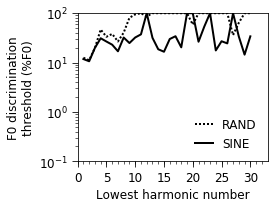

tmp-audioset_speaker_word_brain0_bez2018model_multitask_weights_v11_rand-f0_classifier_ckpt_v01-relu_4.pdf


In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), gridspec_kw={})
util_figures_psychophysics.make_bernox_threshold_plot(ax, results_dict)
plt.tight_layout()
plt.show()

tmp_fn = json_fn.replace('/om2/user/bjmedina/hearinglossnet/saved_models/', '')
tmp_fn = tmp_fn.replace('/','-')
tmp_fn = tmp_fn.replace('-evaluation_metrics.json','.pdf')
tmp_fn = 'tmp-' + tmp_fn
tmp_fn
print(tmp_fn)

fig.savefig(tmp_fn, bbox_inches='tight', pad_inches=0, transparent=False)

